# PV-IN KCNC2 Kv3.2 A new genetic cause of childhood epilepsy


### imports and setup

In [1]:
%load_ext autoreload
%autoreload 2
import logging

from pathlib import Path
from functools import lru_cache
from itertools import product
from neuron import h
from neuron import gui
from tqdm import tqdm
from typing import Iterable, Union
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.cells.pv_nrn import get_pv, get_pv_params, reset_biophys

from src.constants import *
from src.settings import *
from src.data import get_cached_df, get_file_path, set_cache_root, get_cache_root, wide_to_long, concise_df
from src.measure import get_max_propagation, get_ap_times, calculate_failures
from src.run import get_trace, set_relative_nav11bar, set_nrn_prop
from src.utils import get_key, format_nav_loc, perc_decrease, str_to_tuple, nearest_idx, nearest_value, nearest_idx_val, get_last_sec
from src.vis import plot_voltage_trace, set_default_style, save_fig, get_pulse_times, get_pulse_xy
from src.nrn_helpers import init_nrn, env_var

logging.basicConfig(level=logging.INFO)

set_cache_root("D:\\.cache")

init_nrn(celsius=34, v_init=-80) # as in BBP optimisation

h.check_simulator() # method from PV_template.hoc that checks if parameters used during optimisation are the same as those used during simulation

set_default_style()

INFO:nrn_helpers:there were changes in the mod file directory
INFO:nrn_helpers:celsius=34.0 and v_init=-80.0


## Set up

In [2]:
from nrnutils import Section, Mechanism
 # define ion channel parameters
leak = Mechanism('pas', e=env_var()["v_init"], g=1e-5)
hh = Mechanism('hh')
kv3 = Mechanism('SKv3_1') # uses ek and has param gSKv3_1bar
kv3_mut = Mechanism('SKv3_1m')
passive_point_neuron = ppn = Section(L=3, diam=3, mechanisms=[leak, kv3], name='WT')
passive_point_neuron_mutant = ppn_mut = Section(L=30, diam=30, mechanisms=[leak, kv3_mut], name='C165Y')

# Objects
t_vec = h.Vector()
v = h.Vector()
v_mut = h.Vector()
ik = h.Vector()
ik_mut = h.Vector()

# record
t_vec.record(h._ref_t) # only once a section is created
v.record(ppn(0.5)._ref_v)
v_mut.record(ppn_mut(0.5)._ref_v)
ik.record(ppn(0.5)._ref_ik)
ik_mut.record(ppn_mut(0.5)._ref_ik)
vclamp = h.SEClamp(ppn(0.5))
vclamp_mut = h.SEClamp(ppn_mut(0.5))

v_init = env_var()["v_init"]
vclamp.dur1 = vclamp_mut.dur1 = 10
vclamp.dur2 = vclamp_mut.dur2 = 100
vclamp.dur3 = vclamp_mut.dur3 = 100
vclamp.amp1 = vclamp_mut.amp1 = v_init
vclamp.amp2 = vclamp_mut.amp2 = v_init # this will be changed
vclamp.amp3 = vclamp_mut.amp3 = -40
vclamp.rs = vclamp_mut.rs = 0.01

str(ppn)

"Section(L=3.0, Ra=100.0, nseg=1, rallbranch=1.0, diam=3.0, cm=1.0, mechanisms=[Mechanism(name=pas, parameters={'e': -80.0, 'g': 1e-05}),Mechanism(name=SKv3_1, parameters={})], synapses=[], parent=_)"

In [3]:
vclamp_values = np.arange(-65, 50, 5)

h.tstop = max(210, vclamp.dur1 + vclamp.dur2 + vclamp.dur3)

points = pd.DataFrame()

extended_vclamp_values = np.arange(vclamp_values.min(), vclamp_values.max() + 1, 1)


def calc_tail_current(ik_np: np.ndarray, t_np: np.ndarray, vclamp: h.SEClamp):
    """
    Calculates tail current for a given vclamp value
    """
    tail_current = np.mean(
        ik_np[
            (t_np > (vclamp.dur2 + vclamp.dur1))
            & (t_np < (vclamp.dur2 + vclamp.dur1 + 10))
        ]
    )
    return tail_current


def calc_activation_time_constant_tau(
    ik_np: np.ndarray, t_np: np.ndarray, vclamp: h.SEClamp
):
    """
    Calculates activation time constant for a given vclamp value
    """
    activation_ik = ik_np[(t_np > vclamp.dur1) & (t_np < (vclamp.dur2 + vclamp.dur1))]
    # find idx for 2/3 of max
    idx = nearest_idx(activation_ik, activation_ik.max() * (1-np.exp(-1)))
    return t_np[idx]


def calc_deactivation_time_constant_tau(
    ik_np: np.ndarray, t_np: np.ndarray, vclamp: h.SEClamp
):
    """
    Calculates deactivation time constant for a given vclamp value
    """
    # find idx for 1/3 of max
    tail_ik_np = ik_np[
        (t_np > (vclamp.dur2 + vclamp.dur1))
        & (t_np < (vclamp.dur2 + vclamp.dur1 + vclamp.dur3))
    ]
    idx = nearest_idx(tail_ik_np, tail_ik_np.max() * np.exp(-1))
    return t_np[idx]

sample_lines = {
    'v': [],
    'ik': [],
    'ik_mut': [],
}

for amp in tqdm(extended_vclamp_values):
    vclamp.amp2 = vclamp_mut.amp2 = amp

    h.finitialize(env_var()["v_init"])
    h.run()

    t_np = t_vec.as_numpy()
    v_np = v.as_numpy()
    ik_np = ik.as_numpy()
    v_mut_np = v_mut.as_numpy()
    ik_mut_np = ik_mut.as_numpy()

    if amp in vclamp_values:
        sample_lines['v'].append(np.array(v_np)) # copy data
        sample_lines['ik'].append(np.array(ik_np))
        sample_lines['ik_mut'].append(np.array(ik_mut_np))

    tail_current = np.mean(
        ik_np[
            (t_np > (vclamp.dur2 + vclamp.dur1))
            & (t_np < (vclamp.dur2 + vclamp.dur1 + 10))
        ]
    )
    points = pd.concat(
        [
            points,
            pd.DataFrame(
                {
                    "v": [vclamp.amp2, vclamp_mut.amp2],
                    "peak ik": [max(ik_np), max(ik_mut_np)],
                    "tail ik": [
                        calc_tail_current(ik_np, t_np, vclamp),
                        calc_tail_current(ik_mut_np, t_np, vclamp_mut),
                    ],
                    "tau activation": [
                        calc_activation_time_constant_tau(ik_np, t_np, vclamp),
                        calc_activation_time_constant_tau(ik_mut_np, t_np, vclamp_mut),
                    ],
                    "tau deactivation": [
                        calc_deactivation_time_constant_tau(ik_np, t_np, vclamp),
                        calc_deactivation_time_constant_tau(ik_mut_np, t_np, vclamp_mut),
                    ],
                    "Kv3.2": [ppn.name(), ppn_mut.name()],
                },
                # index=[0, 1], # only needed if single row
            ),
        ],
        ignore_index=True,
    )

# clean up dataframe
# convert ik in mA/cm2 to pA/pF using membrane capacitance (uF/cm2)
points["peak ik"] = points["peak ik"] * 1e3 / ppn.cm
points["tail ik"] = points["tail ik"] * 1e3 / ppn.cm


100%|██████████| 111/111 [00:04<00:00, 27.25it/s]


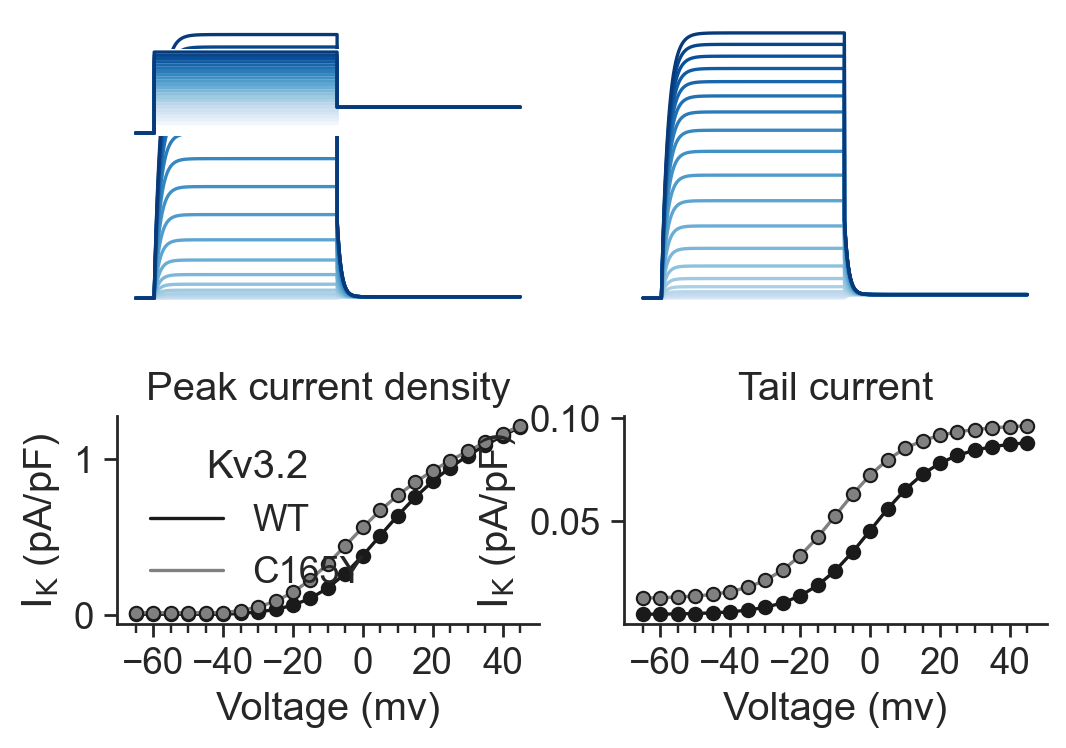

In [4]:
sns.set_palette("Blues", len(vclamp_values))
sns.set_context("paper", font_scale=1.5)

fig, axes = plt.subplot_mosaic(
    [["ik", "ik_mut"], ["ik", "ik_mut"], ["i-v peak", "i-v tail"]],
    gridspec_kw={"height_ratios": [0.8, 1, 2], "hspace": 0.8},
    dpi=200,
)
# create inset axis
axes["v"] = axes["ik"].inset_axes([0.0, 0.6, 1.0, 0.3])

# plot sample lines
for key in sample_lines.keys():
    for line in sample_lines[key]:
        axes[key].plot(t_np, line)

# take only vclamp values
plot_points = points[points["v"].isin(vclamp_values)]

VOLTAGE_MV = "Voltage (mv)"

sns.lineplot(
    data=plot_points,
    x="v",
    y="peak ik",
    ax=axes["i-v peak"],
    hue="Kv3.2",
    palette=["k", "gray"],
    marker="o",
    markeredgecolor="k",
    legend=True,
)
sns.lineplot(
    data=plot_points,
    x="v",
    y="tail ik",
    ax=axes["i-v tail"],
    hue="Kv3.2",
    palette=["k", "gray"],
    marker="o",
    markeredgecolor="k",
    legend=False,
)


axes["v"].set_ylim(env_var()["v_init"] - 5, max(vclamp_values) + 5)
# set ylims the same for ik and ikmut
ymax = max(axes["ik"].get_ylim()[1], axes["ik_mut"].get_ylim()[1])
for ax in [axes["ik"], axes["ik_mut"]]:
    ax.set_ylim(top=ymax)

axes["i-v peak"].set_title("Peak current density")
axes["i-v tail"].set_title("Tail current")

for ax in [axes["v"], axes["ik"], axes["ik_mut"]]:
    sns.despine(ax=ax, left=True, bottom=True)
    ax.set(yticks=[], xticks=[])

for ax in [axes["i-v peak"], axes["i-v tail"]]:
    ax.set_xlabel(VOLTAGE_MV)
    ax.set_ylabel("$\\rm{I_{K}}$ (pA/pF)")
    ax.set_xticks(plot_points["v"], minor=True)
    ax.set_xticks(
        np.arange(vclamp_values.min() + 5, vclamp_values.max() + 5, 20), minor=False
    )


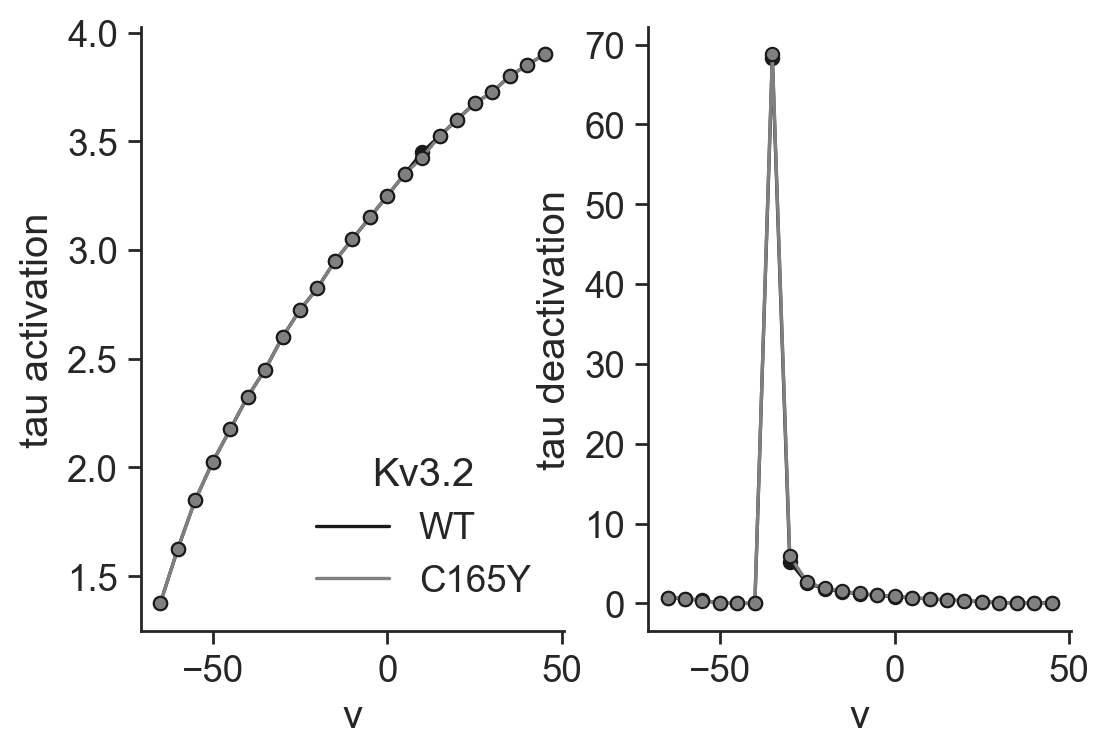

In [5]:
fig, axes = plt.subplot_mosaic(
    [["tau activation", "tau deactivation"]],
)
for i, key in enumerate(["tau activation", "tau deactivation"]):
    sns.lineplot(
        data=plot_points,
        x="v",
        y=key,
        ax=axes[key],
        hue="Kv3.2",
        palette=["k", "gray"],
        marker="o",
        markeredgecolor="k",
        legend=(i==0),
    )


In [6]:
def interpolate(points: pd.DataFrame, step_size: float) -> float:
    """
    Interpolate a point in a line.
    """
    interp_points = points.reindex(index=np.arange(points.index.min(), points.index.max()+1, step_size))
    interp_points = interp_points.interpolate(method="linear", limit_direction="both")
    return interp_points


def find_v_half(points: pd.DataFrame):

    # find v 1/2 point for peak ik
    idx = nearest_idx(points["peak ik"].values, points["peak ik"].max()/2)
    v_half_peak = points.iloc[idx]["v"]
    return idx, v_half_peak


WT
v_half=8.6
C165Y
v_half=1.97


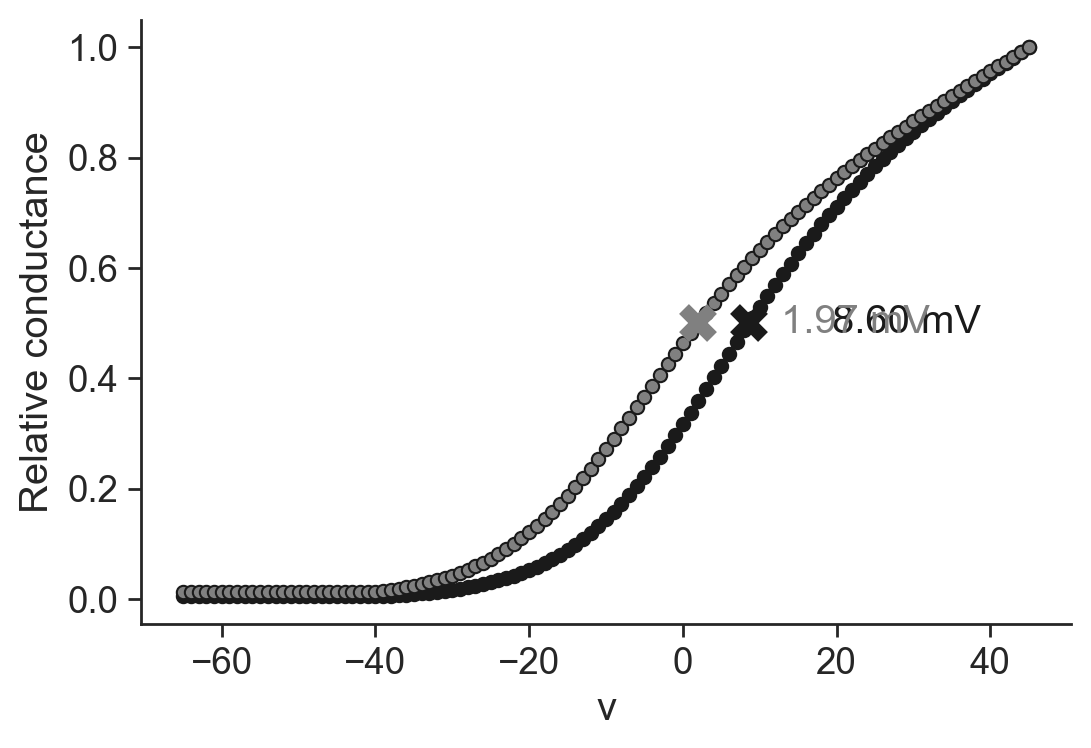

In [7]:
fig, ax = plt.subplots()

colors = ["k", "gray"]

for i, key in enumerate(points["Kv3.2"].unique()):
    print(key)
    df_kv = points[points["Kv3.2"] == key].reset_index()
    interp_points = interpolate(df_kv, 0.01)
    df_kv["Relative conductance"] = df_kv["peak ik"] / df_kv["peak ik"].max()
    interp_points["Relative conductance"] = (
        interp_points["peak ik"] / interp_points["peak ik"].max()
    )

    sns.lineplot(
        data=df_kv,
        x="v",
        y="Relative conductance",
        ax=ax,
        color=colors[i],
        marker="o",
        markeredgecolor="k",
        legend=True,
    )

    v_half_idx, v_half = find_v_half(interp_points)
    print(f"{v_half=}")
    xy = (v_half, interp_points.iloc[v_half_idx]["Relative conductance"])
    ax.annotate(
        f"{xy[0]:.2f} mV",
        xy=xy,
        xytext=(30, 0),
        textcoords="offset points",
        color=colors[i],
        # arrowprops=dict(arrowstyle="->", color="k"),
        va="center",
    )

    ax.plot(*xy, "x", color=colors[i], markersize=10, markeredgewidth=5, zorder=100)


16it [00:00, 236.31it/s]


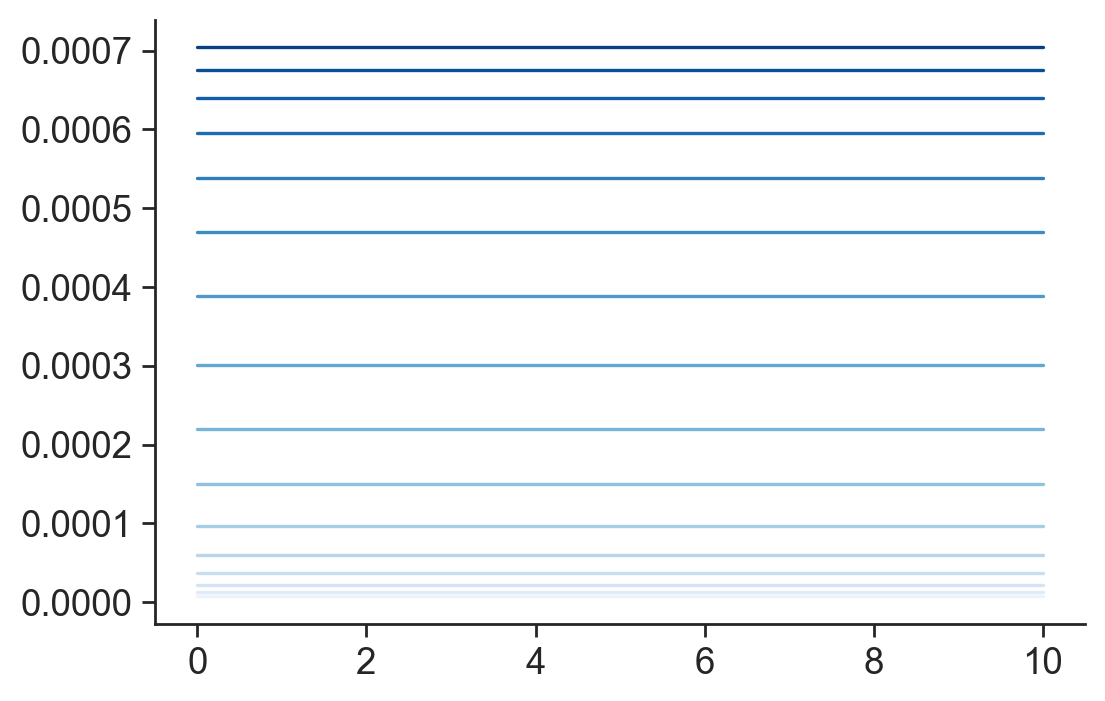

In [22]:
# run a time simulation
T = 10
v = 0
dt = 0.1

v = 0

t_arr = np.arange(0, T + 0.1, dt)
ik_arr = np.zeros_like(t_arr)

ek = -90

x = 0.11
tau_rise = -9.7
y = -46.560
tau_decay = -44.140
tau_scale = 0.2 * 20
gSKv3_1bar = 0.00001


def _ik(v, dt, m, mInf, mTau, gSKv3_1bar, ek):
    m += dt * (mInf - m) / mTau
    return gSKv3_1bar * m * (v - ek)


def _Inf(v, x, tau_rise):
    return 1 / (1 + np.exp(((v - (x)) / (tau_rise))))

v_arr = np.arange(-40, 40, 5)
colors = sns.color_palette("Blues", len(v_arr))

for i, v in tqdm(enumerate(v_arr)):
    m = _Inf(-120, x, tau_rise)

    for idx, t in enumerate(t_arr):
        mInf = _Inf(v, x, tau_rise)
        mTau = tau_scale / (1 + np.exp(((v - (y)) / (tau_decay))))
        ik = _ik(v, dt, m, mInf, mTau, gSKv3_1bar, ek)
        ik_arr[idx] = ik
    plt.plot(t_arr, ik_arr, c=colors[i])
